## Notebook to manually add broad cell-types to the anndata object

In [1]:
!date

Fri Dec 24 13:31:19 EST 2021


#### import libraries and set notebook variables

In [2]:
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context

import warnings
warnings.simplefilter('ignore')

In [3]:
# naming
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
quants_dir = f'{wrk_dir}/demux'
results_dir = f'{wrk_dir}/results'

# in files
data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.subclustered.h5ad'

# out files

# constants
# get cell counts by 'categories'
region_obs_feature = 'Brain_region'
celltype_obs_feature = 'new_anno'
broadtype_obs_feature = 'broad_celltype'

celltypes_dict = {'Astrocyte': ['Astrocyte'],
                  'Microglia': ['Microglia'], 
                  'Oligodendrocyte': ['Oligodendrocyte-1', 'Oligodendrocyte-2', 
                                      'Oligodendrocyte-3'], 'OPC': ['OPC'], 
                  'SPN': ['SPN D1', 'SPN D2', 'SPN D1-2', 'SPN D2-2'], 
                  'ExN': ['ExN CUX2 LAMP5', 'ExN FEZF2', 'ExN RORB THEMIS', 
                          'ExN CUX2 ADARB2', 'ExN RORB', 'ExN LAMP5', 'ExN THEMIS'], 
                  'InN': ['InN ADARB2 VIP', 'InN LHX6 PVALB', 'InN ADARB2 LAMP5', 
                          'InN LHX6 SST'], 
                  'Endothelial': ['Endothelial'], 'Ependymal': ['Ependymal'], 
                  'Mural': ['Mural'], 
                  'Other': ['uncertain', 'uncertain-2', 'uncertain-3', 
                             'Astrocyte-GFAP-Hi']}

#### read the anndata (h5ad) file

In [4]:
%%time
adata = sc.read(data_file, cache=True)
print(adata)

Only considering the two last: ['.subclustered', '.h5ad'].
Only considering the two last: ['.subclustered', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
   

#### take a look at the cell counts by cell type

In [5]:
# get cell counts by 'categories'
categories = [region_obs_feature, celltype_obs_feature]
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            11289
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
ExN RORB              1966
ExN LAMP5             1963
uncertain-3           1929
Ependymal             1853
Mural                 1293
Endothelial            953
Oligodendrocyte-3      806
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Radial Glia              0
Name: new_anno, dtype: int64


#### check cell-type counts by brain region

In [6]:
pd.set_option('display.max_rows', None)
print(adata.obs.groupby(region_obs_feature)[celltype_obs_feature].value_counts())

Brain_region                            
Entorhinal cortex      Oligodendrocyte-1     7785
                       ExN FEZF2             6115
                       Astrocyte             4198
                       uncertain             3894
                       InN ADARB2 VIP        3320
                       ExN CUX2 ADARB2       3059
                       OPC                   2875
                       ExN RORB THEMIS       2509
                       InN LHX6 PVALB        2352
                       ExN CUX2 LAMP5        2346
                       Oligodendrocyte-2     2282
                       InN ADARB2 LAMP5      1993
                       ExN LAMP5             1961
                       uncertain-3           1909
                       InN LHX6 SST          1419
                       Microglia             1219
                       SPN D1                 882
                       SPN D2                 859
                       Ependymal              811
         

#### add broad cell-types based on spricific cell-types from defined dictionary

In [7]:
# in case some aren't in dict default broad to specific
adata.obs[broadtype_obs_feature] = adata.obs[celltype_obs_feature]
# add new categories so values can be set
new_cats = list(set([*celltypes_dict]) - set(adata.obs[broadtype_obs_feature]))
print(new_cats)
adata.obs[broadtype_obs_feature] = adata.obs[broadtype_obs_feature].cat.add_categories(new_cats)
# now add values to the column
for key, value in celltypes_dict.items():
    print(key, value)
    adata.obs.loc[adata.obs[broadtype_obs_feature].isin(value), broadtype_obs_feature] = key

['ExN', 'Other', 'Oligodendrocyte', 'SPN', 'InN']
Astrocyte ['Astrocyte']
Microglia ['Microglia']
Oligodendrocyte ['Oligodendrocyte-1', 'Oligodendrocyte-2', 'Oligodendrocyte-3']
OPC ['OPC']
SPN ['SPN D1', 'SPN D2', 'SPN D1-2', 'SPN D2-2']
ExN ['ExN CUX2 LAMP5', 'ExN FEZF2', 'ExN RORB THEMIS', 'ExN CUX2 ADARB2', 'ExN RORB', 'ExN LAMP5', 'ExN THEMIS']
InN ['InN ADARB2 VIP', 'InN LHX6 PVALB', 'InN ADARB2 LAMP5', 'InN LHX6 SST']
Endothelial ['Endothelial']
Ependymal ['Ependymal']
Mural ['Mural']
Other ['uncertain', 'uncertain-2', 'uncertain-3', 'Astrocyte-GFAP-Hi']


#### check counts

In [8]:
# get cell counts by 'categories'
categories = categories + [broadtype_obs_feature]
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            11289
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
ExN RORB              1966
ExN LAMP5             1963
uncertain-3           1929
Ependymal             1853
Mural                 1293
Endothelial            953
Oligodendrocyte-3      806
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Radial Glia              0
Name: new_anno, dtype: int64
Oligodendrocyte      50129
SPN 

#### visualize umap with new labels

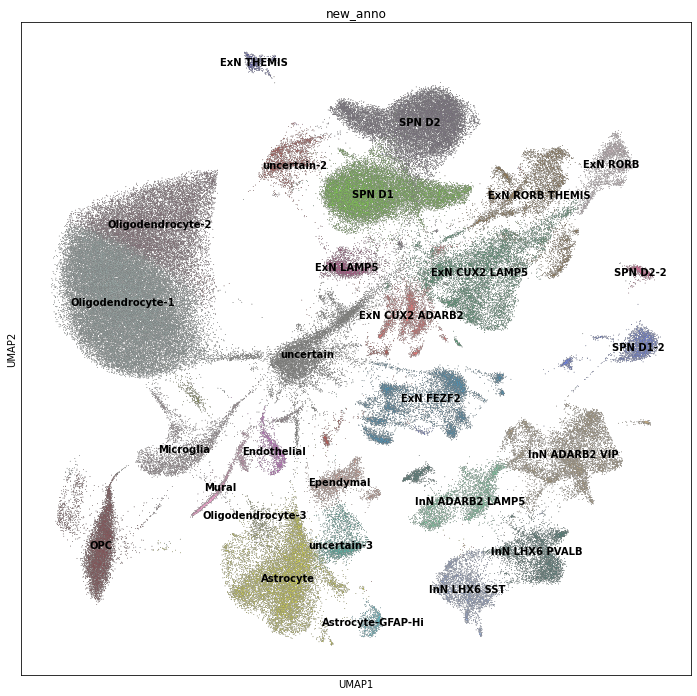

In [9]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=[celltype_obs_feature], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

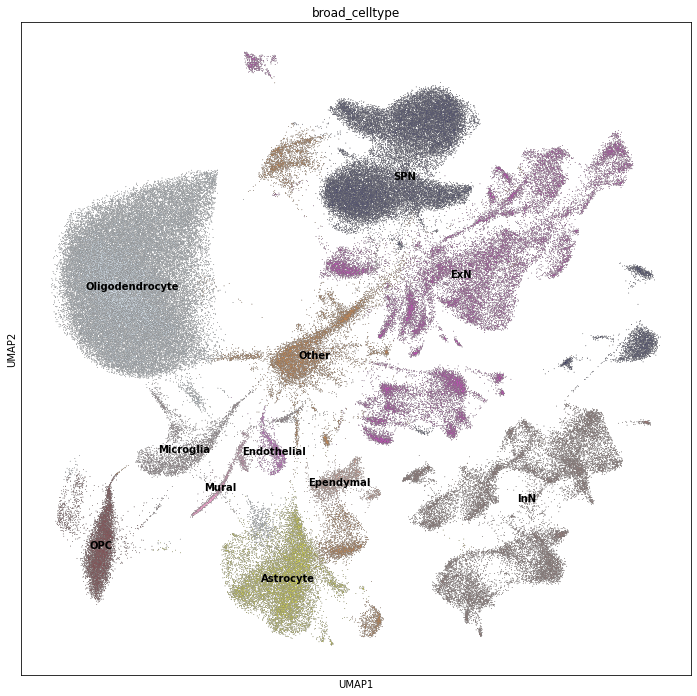

In [10]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=[broadtype_obs_feature], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

#### save to full updated anndata object

In [12]:
%%time
adata.write(data_file)

CPU times: user 1.94 s, sys: 4.81 s, total: 6.75 s
Wall time: 1min 52s


In [13]:
print(adata.obs.groupby(region_obs_feature)[broadtype_obs_feature].value_counts())

Brain_region                            
Entorhinal cortex      ExN                  16056
                       Oligodendrocyte      10458
                       InN                   9084
                       Other                 6843
                       Astrocyte             4198
                       OPC                   2875
                       SPN                   1868
                       Microglia             1219
                       Ependymal              811
                       Mural                  515
                       Endothelial            472
                       ExN FEZF2                0
                       SPN D2                   0
                       ExN CUX2 ADARB2          0
                       ExN CUX2 LAMP5           0
                       uncertain-3              0
                       Oligodendrocyte-3        0
                       uncertain-2              0
                       uncertain                0
         